# Computing Expected Improvement with a Parametric Mean Field Assumption
## What I Need to Do
- [ ] Need to write code that doesn't allocate much memory when solving the hybrid models log likelihood term.

## Questions
- It still isn't clear to me how we compute the log determinant of our KKT-like system. In the limiting case of the uninformative prior, we have block zero entries in our linear system which seem to push the determinant to 0. 

In [36]:
using Profile
using ProfileView
using Polynomials

All the necessary imports for our computations of interest

In [37]:
include("../bayesian_optimization.jl")
# plotlyjs()

bayesian_optimize! (generic function with 1 method)

## Basic Setup

In [38]:
# Visualize 1D test function
polynomial = PolynomialBasisFunction([
        x -> 1., x -> dot(x, x),
])
coefficients = [1., 1.]
polynomial_trend = PolynomialTrend(polynomial, coefficients)
testfn = TestGramacyLee() + polynomial_trend
testfn = TestAckley(16)
if testfn.dim < 3
    tplot(testfn)
end

In [39]:
lbs, ubs = get_bounds(testfn)
domain = lbs[1]:.01:ubs[1]
surrogate_trends, function_trends, initial_observation_sizes = get_trends(0, testfn.dim);

In [40]:
length(surrogate_trends[3])

16

In [41]:
kernel = Matern52()
kernel2 = Matern52()
kernel_lbs, kernel_ubs = [.1], [5.]
θfixed = [0.]
BUDGET = 1

# N = 3
N = length(surrogate_trends[3])
observation_noise = 1e-4
X = randsample(N, testfn.dim, lbs, ubs)
y = testfn(X) + observation_noise * randn(N)
hyperparameter_optimizer_starts = generate_initial_guesses(8, kernel_lbs, kernel_ubs)
inner_optimizer_starts = generate_initial_guesses(8, lbs, ubs)

# hsur = HybridSurrogate(kernel, polynomial, X, y, decision_rule=EI(),
#     observation_noise=observation_noise, capacity=N + BUDGET)
hsur = HybridSurrogate(kernel, surrogate_trends[3], X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N + BUDGET)
sur = Surrogate(kernel2, X, y, decision_rule=EI(),
    observation_noise=observation_noise, capacity=N + BUDGET);

In [42]:
sur = bayesian_optimize!(
    surrogate=sur,
    testfn=testfn,
    spatial_lbs=lbs,
    spatial_ubs=ubs,
    kernel_lbs=kernel_lbs,
    kernel_ubs=kernel_ubs,
    decision_rule_hyperparameters=θfixed,
    inner_optimizer_starts=inner_optimizer_starts,
    hyperparameter_optimizer_starts=hyperparameter_optimizer_starts,
    budget=BUDGET
);

Performing Bayesian Optimization for 1 Iterations
Progress: |-

In [43]:
hsur = bayesian_optimize!(
    surrogate=hsur,
    testfn=testfn,
    spatial_lbs=lbs,
    spatial_ubs=ubs,
    kernel_lbs=kernel_lbs,
    kernel_ubs=kernel_ubs,
    decision_rule_hyperparameters=θfixed,
    inner_optimizer_starts=inner_optimizer_starts,
    hyperparameter_optimizer_starts=hyperparameter_optimizer_starts,
    budget=BUDGET
);

Performing Bayesian Optimization for 1 Iterations
Progress: |-

In [44]:
hsur.X

16×17 Matrix{Float64}:
   7.27884   26.4227     -0.770506  …   -4.33921     5.54526    24.3508
 -12.9479   -23.4745     32.7249       -32.4388     -0.499225   32.7672
   9.20744   -0.406734   -2.70695      -32.0122     -3.65874   -32.7677
  -9.89863   -8.78542    10.0627        -4.26501   -10.8517     32.7679
   2.21207  -12.8069     -5.73293      -10.8327      5.65623    32.768
  14.0627    -5.40878   -21.3551    …   -1.36829    21.7121    -32.7678
   1.13545   13.7768      7.55809       32.6845     -6.19858   -32.7439
  -7.42235   31.2244     11.687        -12.5376      7.97605   -32.7679
 -29.2021    23.7049    -20.9693         0.904057    7.82478    32.768
  -7.84157  -30.8276     28.8903       -17.4659      0.851132  -32.7679
  -9.98623   -1.51056    26.1769    …  -26.5092     11.4625     32.7126
  -9.37103    9.02184    23.5592        23.545     -16.8824    -32.7677
   1.13132   13.2351    -31.1884       -16.7603     24.7442     32.766
  31.46      20.1843    -11.9661        32.4

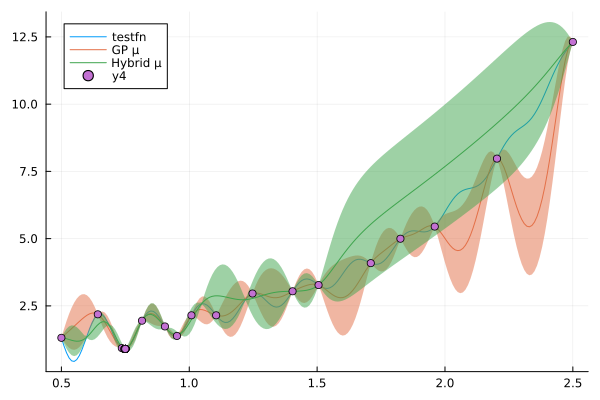

In [18]:
domain = lbs[1]:.01:ubs[1]
μ = similar(domain) # Predictive mean for standard model: f(x) ~ Z(x)
μ2 = similar(domain) # Predictive mean for the hybrid model: f(x) ~ P(x)c + Z(x)
∇μ2 = similar(domain)
Hμ2 = similar(domain)
σ = similar(domain)
σ2 = similar(domain)
∇σ2 = similar(domain)
Hσ2 = similar(domain)
EIx = similar(domain)
EIx2 = similar(domain)

for (i, x) in enumerate(domain)
    sx = sur([x], [0.])
    hsx = hsur([x], [0.])
    
    μ[i] = sx.μ
    μ2[i] = hsx.μ
    ∇μ2[i] = first(hsx.∇μ)
    Hμ2[i] = first(hsx.Hμ)
    σ[i] = sx.σ
    σ2[i] = hsx.σ
    ∇σ2[i] = first(hsx.∇σ)
    Hσ2[i] = first(hsx.Hσ)
    EIx[i] = eval(sx)
    EIx2[i] = eval(hsx)
end

plot(domain, [testfn([x]) for x in domain], label="testfn")
plot!(domain, μ, ribbons=2σ, label="GP μ")
plot!(domain, μ2, ribbons=2σ2, label="Hybrid μ")
scatter!(get_active_covariates(sur)', get_active_observations(sur))

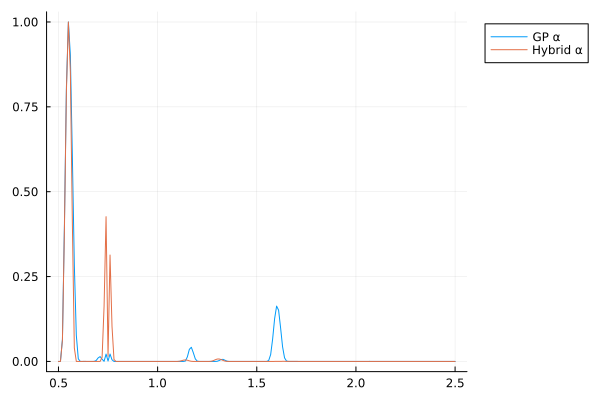

In [19]:
plot(domain, stdize(EIx), label="GP α")
plot!(domain, stdize(EIx2), label="Hybrid α", legend=:outertopright)
# plot!(domain, stdize(POIx), label="Probability of Improvement")
# plot!(domain, stdize(LCBx), label="Lower Confidence Bound")

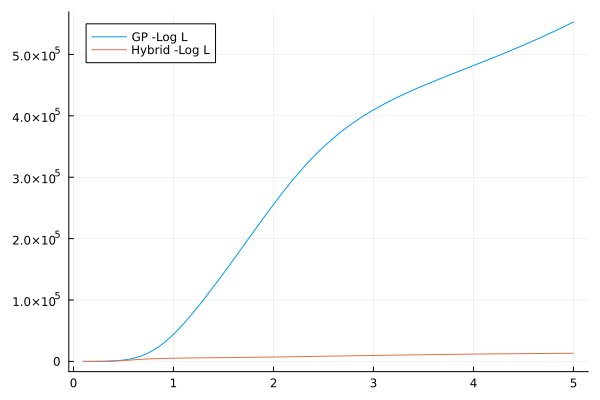

In [22]:
hyperparameter_grid = kernel_lbs[1]:.01:kernel_ubs[1]
results = similar(hyperparameter_grid)
grad_results = similar(hyperparameter_grid)
results_hybrid = similar(hyperparameter_grid)
grad_results_hybrid = similar(hyperparameter_grid)
fd_hybrid_results = similar(hyperparameter_grid)
fd_results = similar(hyperparameter_grid)
h = 1e-6

for (i, hyperparameter) in enumerate(hyperparameter_grid)
    set_kernel!(
        sur,
        set_hyperparameters!(
            get_kernel(sur),
            [hyperparameter]
        )
    )
    set_kernel!(
        hsur,
        set_hyperparameters!(
            get_kernel(hsur),
            [hyperparameter]
        )
    )
    results_hybrid[i] = log_likelihood(hsur)
    grad_results_hybrid[i] = first(∇log_likelihood(hsur))
    results[i] = log_likelihood(sur)
    grad_results[i] = first(∇log_likelihood(sur))

    # FD Hybrid
    set_kernel!(
        hsur,
        set_hyperparameters!(
            get_kernel(hsur),
            [hyperparameter + h]
        )
    )
    llp = log_likelihood(hsur)

    set_kernel!(
        hsur,
        set_hyperparameters!(
            get_kernel(hsur),
            [hyperparameter - h]
        )
    )
    llm = log_likelihood(hsur)
    
    fd_hybrid_results[i] = (llp - llm) / 2h

    # FD Standard
    set_kernel!(
        sur,
        set_hyperparameters!(
            get_kernel(sur),
            [hyperparameter + h]
        )
    )
    llp = log_likelihood(sur)

    set_kernel!(
        sur,
        set_hyperparameters!(
            get_kernel(sur),
            [hyperparameter - h]
        )
    )
    llm = log_likelihood(sur)
    
    fd_results[i] = (llp - llm) / 2h
end

plot(hyperparameter_grid, -results, label="GP -Log L")
plot!(hyperparameter_grid, -results_hybrid, label="Hybrid -Log L")

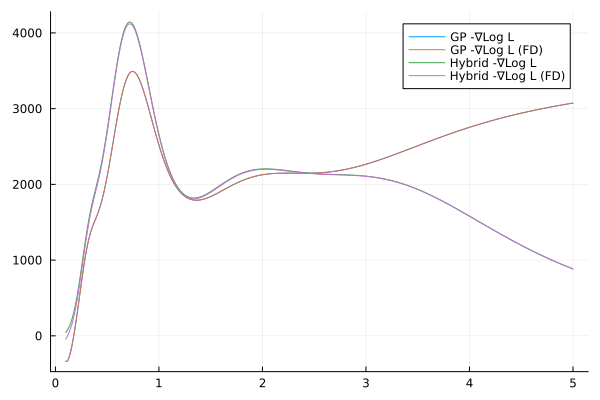

In [12]:
plot(hyperparameter_grid, -grad_results, label="GP -∇Log L")
plot!(hyperparameter_grid, -fd_results, label="GP -∇Log L (FD)")
plot!(hyperparameter_grid, -grad_results_hybrid, label="Hybrid -∇Log L")
plot!(hyperparameter_grid, -fd_hybrid_results, label="Hybrid -∇Log L (FD)")